**Imports**

In [1]:
# wiesel : airsense_env_tsai_031
from imports import * 
from functions import *
from archs import *
from mylearner import *
%matplotlib inline
# %load_ext tensorboard

/arca-scratch/aifa/anaconda/envs/airsense_env_tsai_031/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Loading annotated data**

In [2]:
from loading_data import *

data shape: (64171, 23)
        oxygen      pm10     co  temperature    co2    so2    no2       pm1  \
0      20.936  0.548238  1.562       24.276  455.7  -1.96  23.93  0.396847   
1      20.938  0.678546  1.562       24.274  454.4  -2.06  23.90  0.375806   
2      20.937  0.788452  1.562       24.273  454.5  -2.39  23.96  0.447566   
3      20.937  0.890764  1.562       24.271  454.5  -2.69  23.87  0.558607   
4      20.937  0.844628  1.562       24.268  455.0  -2.83  23.90  0.570323   
...       ...       ...    ...          ...    ...    ...    ...       ...   
44440  20.233  1.471562  1.472       18.350  448.2  25.15  23.51  1.103393   
44441  20.234  1.476924  1.472       18.350  448.3  25.02  23.44  1.049043   
44442  20.233  1.373389  1.472       18.351  449.4  25.04  23.49  1.043940   
44443  20.233  1.454923  1.472       18.350  448.8  25.06  23.57  1.065992   
44444  20.233  1.249064  1.471       18.348  449.2  24.99  23.69  1.031303   

        dewpt      timestamp  ...     

**Encode target classes (person and window open) classes**

In [3]:
df1 = encode_classes(d1)
df2 = encode_classes(d2)
df = encode_classes(data)

0    18144
1     1440
2      139
4        2
3        1
Name: person, dtype: int64
0    18701
1     1025
Name: window_open, dtype: int64
(19726, 23)
0    43791
1      604
2       50
Name: person, dtype: int64
0    44156
1      289
Name: window_open, dtype: int64
(44445, 23)
0    61935
1     2044
2      189
4        2
3        1
Name: person, dtype: int64
0    62857
1     1314
Name: window_open, dtype: int64
(64171, 23)


**filtering data**

In [4]:
# h2s column has only NaN values, also drop timestamp,datetime,deviceid
df.drop(columns=['h2s','timestamp','deviceid'],inplace=True)
df1.drop(columns=['h2s','timestamp','deviceid'],inplace=True)
df2.drop(columns=['h2s','timestamp','deviceid'],inplace=True)

**Missing values, drop NAN**

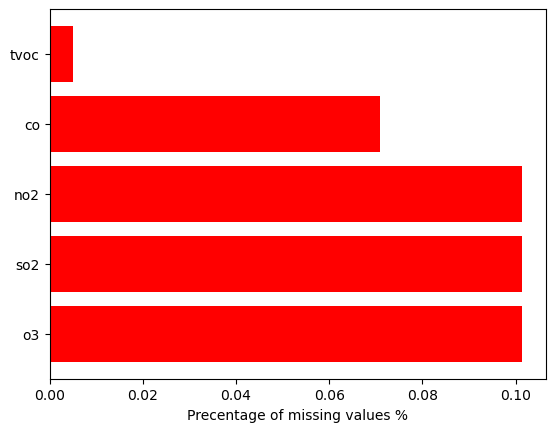

maximum number of missing values per column=  20 

   column  count  percentage
12     o3     20    0.101389
5     so2     20    0.101389
6     no2     20    0.101389
2      co     14    0.070972
9    tvoc      1    0.005069


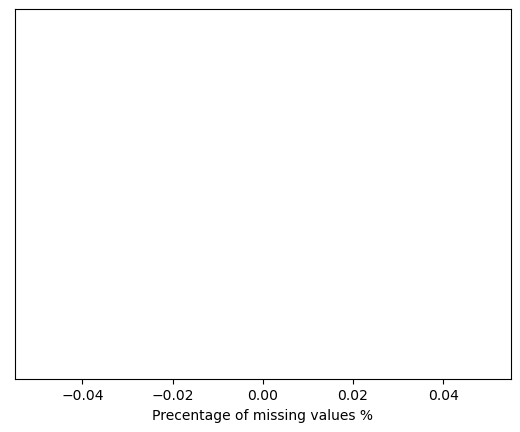

maximum number of missing values per column=  nan 

Empty DataFrame
Columns: [column, count, percentage]
Index: []


In [5]:
plot_missing(df1)
plot_missing(df2)

#### substitute NaN values with mean 
## polynomial interpolation with degree > 1 uses index, also convert dtype to float to work
df1 = impute_NaN(df1)
df2 = impute_NaN(df2)
############## conmbine into df 

df = concat(df1,df2)
df.columns=df1.columns

### drop datetime column and store it before for visualization
datetime_df = df.datetime
datetime_df1 = df1.datetime
datetime_df2 = df2.datetime

df.drop(columns=['datetime'],inplace=True)
df1.drop(columns=['datetime'],inplace=True)
df2.drop(columns=['datetime'],inplace=True)



**minimized dataset for our classification task, drop  rows for testing**

In [6]:

print(df['person'].value_counts(),'\n',df['window_open'].value_counts(),'\n')

#### combine classes of more than 1 person to 1 person as there exists too little of them
lc = df.loc[lambda x: x['person'] > 1]
df.loc[lc.index,'person'] = 1

lc = df1.loc[lambda x: x['person'] > 1]
df1.loc[lc.index,'person'] = 1

lc = df2.loc[lambda x: x['person'] > 1]
df2.loc[lc.index,'person'] = 1

print(df['person'].value_counts(),'\n',df['window_open'].value_counts(),'\n')


############### drop  rows for testing
### november (one month) for testing
df2_test = df2.iloc[df2.shape[0]-22000:df2.shape[0]-21700] ## to get better visualization on less focused data
datetime_test = datetime_df2.iloc[datetime_df2.shape[0]-22000:datetime_df2.shape[0]-21700]
df2 = df2.drop(index = df2.index[df2.shape[0]-22000:]) ### to keep the sequence order drop from last
datetime_df2 = datetime_df2.drop(index = datetime_df2.index[datetime_df2.shape[0]-22000:])


### for visualization
datetime_train = concat(datetime_df1,datetime_df2)
df_train = concat(df1,df2)
df_train.columns=df1.columns

# df2.reset_index(drop=True,inplace=True)
# df2_test.reset_index(drop=True,inplace=True)

df2_test_targets = df2_test.filter(['person','window_open'])
df2_test_features = df2_test.drop(columns=['person','window_open']) 




targets = df.filter(['person','window_open'])
features = df.drop(columns=['person','window_open']) 


targets1 = df1.filter(['person','window_open'])
features1 = df1.drop(columns=['person','window_open']) 

targets2 = df2.filter(['person','window_open'])
features2 = df2.drop(columns=['person','window_open']) 



### minimized data
l_ = ['humidity','temperature','tvoc','oxygen','co2','co','pressure','o3','sound','person','window_open']
f_ = ['humidity','temperature','tvoc','oxygen','co2','co','pressure','o3','sound']
### from leipzig data
# l_ = ['humidity_abs','temperature','tvoc','oxygen','co2','co','no2','o3','person','window_open']
# f_ = ['humidity_abs','temperature','tvoc','oxygen','co2','co','no2','o3']

df_mini1 = df1.filter(l_)
print(df_mini1.shape,'\n',df_mini1['person'].value_counts(),'\n',df_mini1['window_open'].value_counts(),'\n')
features_mini1 = features1.filter(f_)
# print(targets1.iloc[:,0].value_counts())

df_mini2 = df2.filter(l_)
print(df_mini2.shape,'\n',df_mini2['person'].value_counts(),'\n',df_mini2['window_open'].value_counts(),'\n')
features_mini2 = features2.filter(f_)
# print(targets2.iloc[:,0].value_counts())

df2_test_mini = df2_test.filter(l_)
print(df2_test_mini.shape,'\n',df2_test_mini['person'].value_counts(),'\n',df2_test_mini['window_open'].value_counts(),'\n')
df2_test_features_mini = df2_test_features.filter(f_)

## whole df
df_mini = df.filter(l_)
print(df_mini.shape,'\n',df_mini['person'].value_counts(),'\n',df_mini['window_open'].value_counts(),'\n')
features_mini = features.filter(f_)
# print(targets2.iloc[:,0].value_counts())


0    61915
1     2044
2      189
4        2
3        1
Name: person, dtype: int64 
 0    62837
1     1314
Name: window_open, dtype: int64 

0    61915
1     2236
Name: person, dtype: int64 
 0    62837
1     1314
Name: window_open, dtype: int64 

(19706, 11) 
 0    18124
1     1582
Name: person, dtype: int64 
 0    18681
1     1025
Name: window_open, dtype: int64 

(22445, 11) 
 0    21852
1      593
Name: person, dtype: int64 
 0    22206
1      239
Name: window_open, dtype: int64 

(300, 11) 
 0    245
1     55
Name: person, dtype: int64 
 0    259
1     41
Name: window_open, dtype: int64 

(64151, 11) 
 0    61915
1     2236
Name: person, dtype: int64 
 0    62837
1     1314
Name: window_open, dtype: int64 



**Perform undersampling and segmentation**

read yaml config file

In [7]:
with open('config_AE.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)
    
under_window = hyperparams['sample_segment']['under_window']
seq_len = hyperparams['sample_segment']['seq_len']
stride = hyperparams['sample_segment']['stride']
sliding_mode = hyperparams['sample_segment']['sliding_mode']
all_features = hyperparams['sample_segment']['all_features']

under sample and segment

In [8]:
## undersampling and sliding
sampling = hyperparams['sample_segment']['sampling']
if sampling:

    X1,y1= under_sample(df1,under_window,seq_len,stride,sliding_mode=sliding_mode)
    X2,y2= under_sample(df2,under_window,seq_len,stride,sliding_mode=sliding_mode)
else:

    X1,y1= sliding(seq_len,stride,features1,targets1,mode=sliding_mode)
    X2,y2= sliding(seq_len,stride,features2,targets2,mode=sliding_mode)



X = concat(X1,X2)
y = concat(y1,y2)
X.shape, y.shape


((5054, 17, 7), (5054, 2))

**splitting sets and standardization**

**using sklearn**

In [9]:
###### splitting
# splits = TrainValidTestSplitter(valid_size=0.2,test_size=0.1)(y) ##### we have test set here
splits = TrainValidTestSplitter(valid_size=0.1)(y) ##### we DON'T have test set here
x_train = np.zeros(X[splits[0]].shape,dtype=np.float32)
y_train = y[splits[0]]
x_valid = np.zeros(X[splits[1]].shape,dtype=np.float32)
y_valid = y[splits[1]]
#### if splitted
# x_test = np.zeros(X[splits[2]].shape,dtype=np.float32)
# y_test = y[splits[2]]

#different test set
### uses stride = 1 to check all time points
x_test_, y_test = sliding(seq_len,1,df2_test_features,df2_test_targets,mode=sliding_mode)
x_test = np.zeros(x_test_.shape,dtype=np.float32) 
#################



#### standardization
scalers = {}
for i in range(x_train.shape[1]): ## n_features
    scalers[i] = StandardScaler()
    scalers[i].fit(np.unique((X[splits[0]])[:, i, :]).reshape(-1,1)) ### as we have overlapping samples
    x_train[:, i, :] = scalers[i].transform((X[splits[0]])[:, i, :].reshape(-1,1)).reshape(x_train.shape[0],x_train.shape[-1])
    x_valid[:, i, :] = scalers[i].transform((X[splits[1]])[:, i, :].reshape(-1,1)).reshape(x_valid.shape[0],x_valid.shape[-1])
    # x_test[:, i, :] = scalers[i].transform((X[splits[2]])[:, i, :].reshape(-1,1)).reshape(x_test.shape[0],x_test.shape[-1]) ## from splitting
    x_test[:, i, :] = scalers[i].transform((x_test_)[:, i, :].reshape(-1,1)).reshape(x_test.shape[0],x_test.shape[-1]) ## test set from outside
print(x_train.shape,x_valid.shape,x_test.shape)

(4549, 17, 7) (505, 17, 7) (294, 17, 7)


**tsai LEARNER**

read config file

In [10]:
with open('config_AE.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

epochs = hyperparams['model']['epochs']
bs = hyperparams['model']['bs']
num_workers = hyperparams['model']['num_workers']
embed_size = hyperparams['model']['embed_size']

**get pretrained encoder  TODO EncoderClassifier vs AutoEncoder ?! **

In [11]:

new_autoencoder = AutoEncoder(x_train.shape[1],embed_size=embed_size)
pretrained_encoder = False

if pretrained_encoder:
    pretrained_dict = torch.load(f'/afs/tu-chemnitz.de/home/urz/a/abom/internship/models/{AutoEncoder.__name__}_{seq_len}_shuffled_{embed_size}.pt')
    new_autoencoder.load_state_dict(pretrained_dict)

### get ptrtrained encoder
enc = new_autoencoder.encoder

**Train [note freezing the encoder before fitting]**

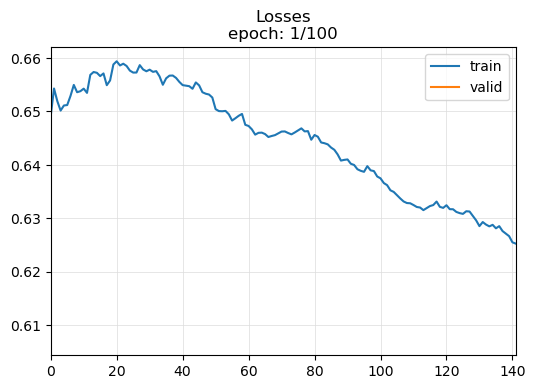

No improvement since epoch 72: early stopping


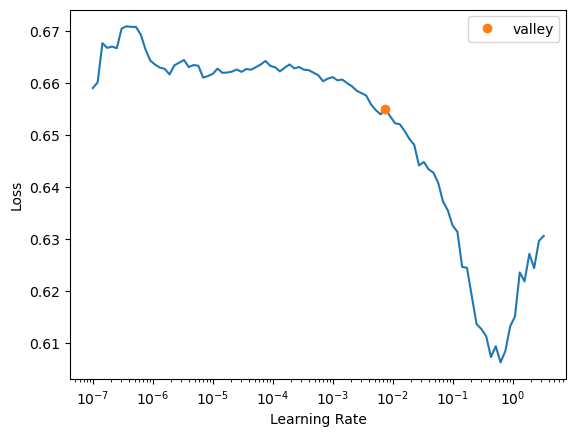

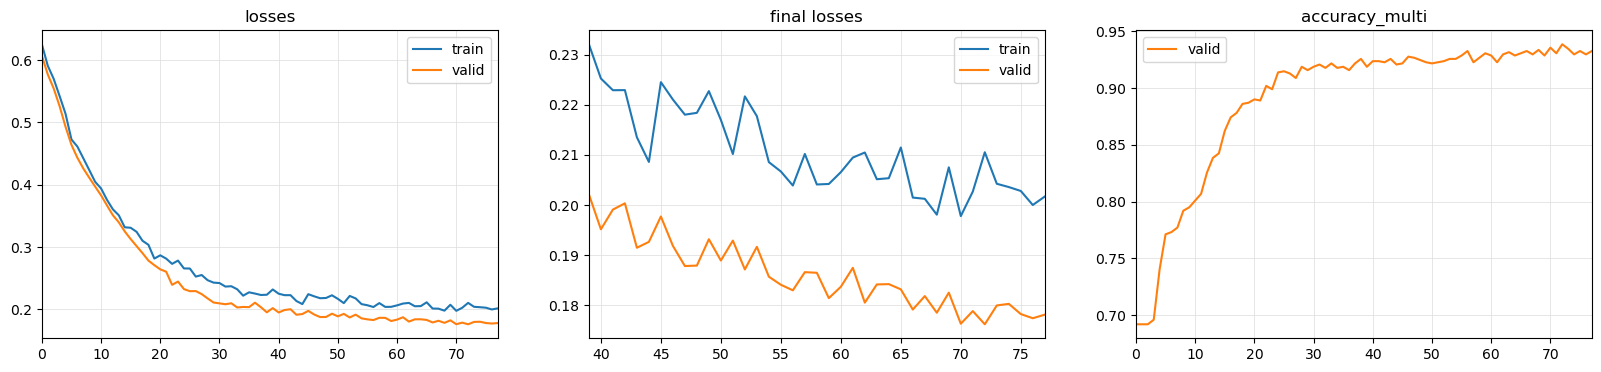

time= 158.32709336280823
No. of trainable parameters= 1302
train loss = 0.20168714225292206, valid loss = 0.17813710868358612
FlattenedLoss of BCEWithLogitsLoss()


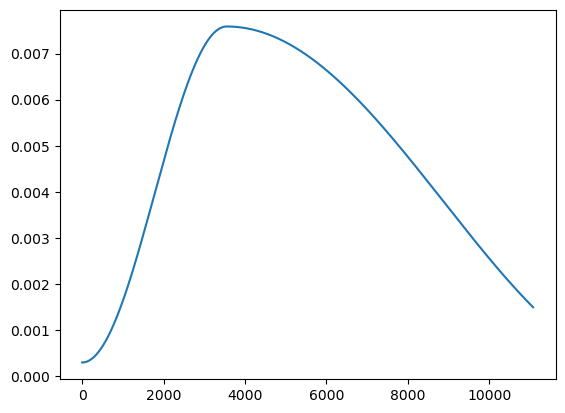

In [12]:
######## remove sigmoid from the network*****************

# tfms  = [None, Categorize()] ## single label
tfms  = [None, MultiCategorize()] ## multi label
batch_tfms = TSStandardize()

## single label
# tsets = TSDatasets(x_train, y_train[:,0], tfms=tfms, inplace=True)
# vsets = TSDatasets(x_valid, y_valid[:,0], tfms=tfms, inplace=True)
## multi label
tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
vsets = TSDatasets(x_valid, y_valid, tfms=tfms, inplace=True)
######################
dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = bs, num_workers=num_workers) ### note the normalization


#############################################################

k={'encoder':enc,'n_neurons':100, 'embed_size':embed_size,'fc_dropout':0.5}
network = f'EncoderClassifier, embedding size = {embed_size}'
model = create_model(EncoderClassifier, dls.vars,dls.c,dls,**k)
# learn = Learner(dls, model, metrics=accuracy,cbs = ShowGraph()) ### single label
#### note the accuracy_multi and MultiCategorize() contains BCEwithlogits not normal BCE
learn = Learner(dls, model, metrics=accuracy_multi,cbs = ShowGraph()) ### multi label
##########################################################################3

freeze(learn)  #### freeze encoder

###########################################################################
start = time.time()
learn.fit_one_cycle(epochs,learn.lr_find().valley,cbs = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.00001, patience=5)) ## learning rate annealing
elapsed = time.time()-start
print(f'time= {elapsed}')
print(f'No. of trainable parameters= {count_parameters(model)}')
print(f'train loss = {learn.recorder.values[-1][0]}, valid loss = {learn.recorder.values[-1][1]}')
plt.figure()
plt.plot(learn.recorder.lrs)

print(learn.loss_func)
metrics = np.array(learn.recorder.values)

# save the model as state dictionary 
torch.save(learn.model.state_dict(), f'{learn.model._get_name()}.pt')
#### unfreeze encoder
unfreeze(learn) 


### To read already available networks

In [13]:
# tfms  = [None, MultiCategorize()] ## multi label
# batch_tfms = TSStandardize()

# ## single label
# # tsets = TSDatasets(x_train, y_train[:,0], tfms=tfms, inplace=True)
# # vsets = TSDatasets(x_valid, y_valid[:,0], tfms=tfms, inplace=True)
# ## multi label
# tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
# vsets = TSDatasets(x_valid, y_valid, tfms=tfms, inplace=True)
# ######################
# dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization

# ### get encoderclassifier
# k={'encoder':enc,'n_neurons':100, 'embed_size':embed_size}
# network = f'EncoderClassifier, embedding size = {embed_size}'


# # load 
# pretrained_dict = torch.load(f'/afs/tu-chemnitz.de/home/urz/a/abom/internship/models/{EncoderClassifier.__name__}.pt')
# model = create_model(EncoderClassifier, dls.vars,dls.c,dls,**k)
# model.load_state_dict(pretrained_dict)

# # learn = Learner(dls, model, metrics=accuracy,cbs = ShowGraph()) ### single label
# #### note the accuracy_multi and MultiCategorize() contains BCEwithlogits not normal BCE
# learn = Learner(dls, model, metrics=accuracy_multi,cbs = ShowGraph()) ### multi label

 ### EVALUATION ON TEST DATA SET + Using PR curves**

Accuracy [Both]: 92.17687
Accuracy [person]: 96.25850
Accuracy [window_open]: 95.23810


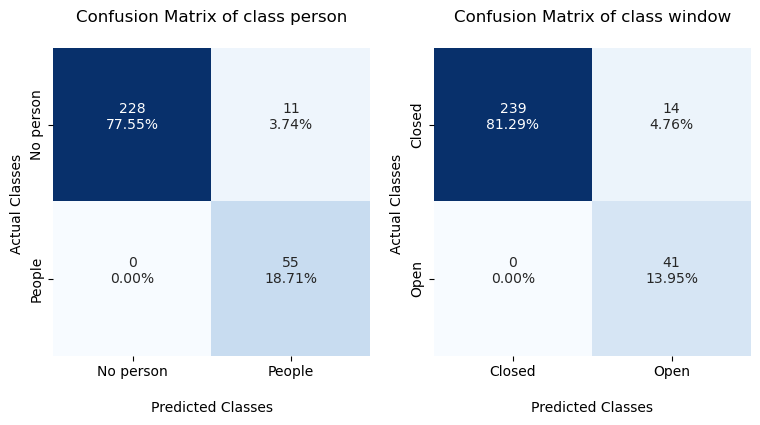

F1 score [person]: 0.9090909090909091

precision [person]: 0.8333333333333334

recall [person]: 1.0

F1 score [window]: 0.8541666666666666

precision [window]: 0.7454545454545455

recall [window]: 1.0



In [14]:
#### Adding dataset to apply same dls valid tfms on test
def evaluate_test_data(_x_test, _y_test, _tfms,_learn):
    x_test = _x_test
    y_test = _y_test
    tfms = _tfms
    learn = _learn
    
    ### standardize test set with train parameters (apply Multicategorize transform)
    test_set = TSDatasets(x_test, y_test, tfms=tfms, inplace=True) # multi_label
    # test_set = TSDatasets(x_test, y_test[:,0], tfms=tfms, inplace=True) # single_label
    test_dl   = TSDataLoader(test_set, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization
    # next(iter(test_dl))


    #### evaluating

    test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,with_decoded=True)#,reorder = False)
    test_preds = test_preds.long() ### to convert bool to int

    ###############################################################################################
    ###### use PR curve to get best threshold for each class on given test set
    ##############################################################################################
    # # # class person
    # # threshold_person, _ = plot_PR_curve('person',test_targets[:,0],test_probas[:,0])
    # # ### class window_open
    # # threshold_window, _ =plot_PR_curve('window',test_targets[:,1],test_probas[:,1])
    # threshold_person,threshold_window = plot_PR_curve_both(test_targets,test_probas)
    # test_preds[:,0] = (test_probas[:,0]>=threshold_person)
    # test_preds[:,1] = (test_probas[:,1]>=threshold_window)
    #################################################################################################

    ## single label
    ### number of classes in validation set
    # n_classes = pd.DataFrame(test_targets).value_counts().shape[0]
    # plot_confusion(test_targets,test_preds,n_classes,name = 'person')
    # print(f'Accuracy: {(test_targets == test_preds).float().mean():0.5f}')  
    # print(f'F1 score: {f1_score(test_targets,test_preds)}\n') # to get f1 score for each class use (average=None)
    # print(f'precision: {precision_score(test_targets,test_preds)}\n') 
    # print(f'recall: {recall_score(test_targets,test_preds)}\n') 

    ## multi label
    print(f'Accuracy [Both]: {(100/test_targets.shape[0])*torch.all((test_preds == test_targets),dim=1).sum():0.5f}') ## multi-label
    print(f'Accuracy [person]: {(100/test_targets.shape[0])*(test_preds[:,0] == test_targets[:,0]).sum():0.5f}') ## multi-label
    print(f'Accuracy [window_open]: {(100/test_targets.shape[0])*(test_preds[:,1] == test_targets[:,1]).sum():0.5f}') ## multi-label
    n_classes = test_targets.shape[1]

    ## confusion matrices
    confusion_fig = plot_confusion_both(test_targets,test_preds,n_classes)
    ## person class
    # plot_confusion(test_targets[:,0],test_preds[:,0],n_classes,name = 'person')
    print(f'F1 score [person]: {f1_score(test_targets[:,0],test_preds[:,0])}\n')
    print(f'precision [person]: {precision_score(test_targets[:,0],test_preds[:,0])}\n') 
    print(f'recall [person]: {recall_score(test_targets[:,0],test_preds[:,0])}\n') 

    ### window class
    # plot_confusion(test_targets[:,1],test_preds[:,1],n_classes,name = 'window')
    print(f'F1 score [window]: {f1_score(test_targets[:,1],test_preds[:,1])}\n') 
    print(f'precision [window]: {precision_score(test_targets[:,1],test_preds[:,1])}\n') 
    print(f'recall [window]: {recall_score(test_targets[:,1],test_preds[:,1])}\n') 

    return test_targets,test_preds,confusion_fig


test_targets,test_preds,confusion_fig = evaluate_test_data(_x_test= x_test, _y_test = y_test, _tfms = tfms,_learn = learn)



**investigate distribution of wrong predictions, and smoothing** 

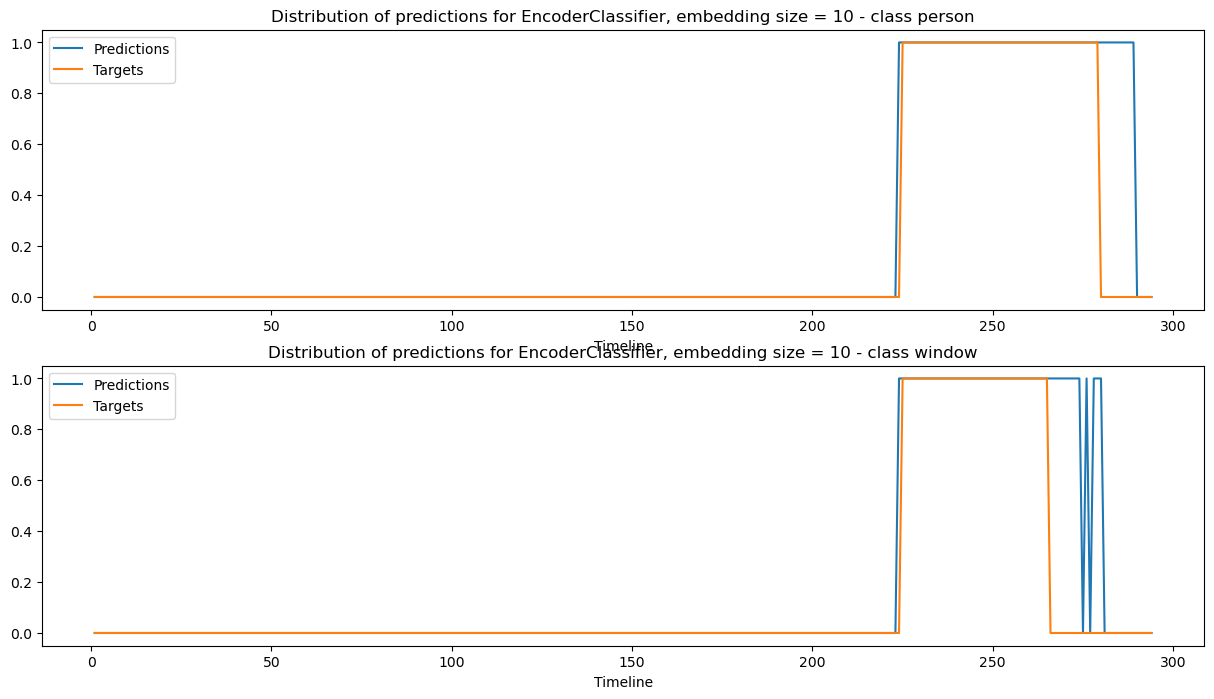

In [15]:
#### single label
# ## plot targets vs predictions person
# plot_distribution(test_targets,test_preds,'person')
# ## plot FP, FN 
# plot_fp_fn(test_targets,test_preds,'person')
#############################################################################################################
### smoothing
# test_preds = smoothing_predictions(test_preds,2)
###############################################################################################################
#### multi label
fig = plot_distribution_both(test_targets,test_preds, network)


**optuna for HP optimization**

load yaml file

In [ ]:
with open('config_AE.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)
epochs = hyperparams['optuna']['epochs']
optuna_trials = hyperparams['optuna']['trials']
bs = hyperparams['model']['bs']
num_workers = hyperparams['model']['num_workers']

optimize (notice freeze for autoencoder)

In [ ]:
tfms  = [None, MultiCategorize()] 
batch_tfms = TSStandardize()

tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
# vsets = TSDatasets(x_test, y_test, tfms=tfms, inplace=True)
vsets = TSDatasets(x_valid, y_valid, tfms=tfms, inplace=True)

dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization


def objective(trial:optuna.Trial):
    
    rt = trial.study.study_name.replace('_AE_study','')
    study_folder = f'/scratch/aifa/MyRepo/SmartAirsense/internship/TimeSeriesClassification/Experiments/Autoencoder/{rt}'
    dat_ = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    trial_folder = os.path.join(study_folder,f'trial_{trial._trial_id}_{dat_}')
    if not os.path.exists(trial_folder):
        os.mkdir(trial_folder)
    # Define search space here. Supported search space are 

    lr = trial.suggest_float("Learning_rate", 1e-8, 1e-6, log=True)

    n_filters = trial.suggest_int('num_filters',50,150,step = 10)
    # k={'encoder':enc,'n_neurons':100}
    k={'encoder':enc,'n_neurons':n_filters, 'embed_size':embed_size,'fc_dropout':0.5}
    model = create_model(EncoderClassifier, dls.vars,dls.c,dls,**k)
    #### note the F1_multi and MultiCategorize() contains BCEwithlogits not normal BCE
    learn = Learner(dls, model, metrics=F1_multi,lr=lr)

    ####################################
    freeze(learn) #### for autoencoder
    ######################################
    learn.fit_one_cycle(epochs,learn.lr_find().valley) ## learning rate annealing
    
    # # return the F1 score - learn.recorder.values returns [[train_loss, valid_loss, F1_multi]]
    metric_before_pred = learn.recorder.values[-1][-1]
    
    test_targets,test_preds,confusion_fig = evaluate_test_data(_x_test= x_test, _y_test = y_test, _tfms = tfms,_learn = learn)
    fig = plot_distribution_both(test_targets,test_preds, network='AE')
    fig.savefig(os.path.join(trial_folder, 'plot_dist.png'))
    confusion_fig.savefig(os.path.join(trial_folder, 'conf_matrix.png'))
    trial_params = os.path.join(trial_folder,'trial_params.yaml')
    with open(trial_params,'w') as f:
        for key, value in trial.params.items():
            f.write("    {}: {}\n".format(key, value))
    
    return metric_before_pred

            
    # return the F1 score - learn.recorder.values returns [[train_loss, valid_loss, F1_multi]]
    # return learn.recorder.values[-1][-1]

    # return the valid_loss - learn.recorder.values returns [[train_loss, valid_loss, acc]]
    # return learn.recorder.values[-1][1]

In [ ]:

dat = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
ae_folder = f'/scratch/aifa/MyRepo/SmartAirsense/internship/TimeSeriesClassification/Experiments/Autoencoder/{dat}'
if not os.path.exists(ae_folder):
    os.mkdir(ae_folder)
    
study = optuna.create_study(direction='maximize', 
                            pruner=optuna.pruners.HyperbandPruner(),
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name=f"{dat}_AE_study")



study.optimize(objective, n_trials=optuna_trials, show_progress_bar=True)

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
best_trial_params = os.path.join(ae_folder,f'best_trial_params_{trial._trial_id}.yaml')
with open(best_trial_params,'w') as f:
    for key, value in trial.params.items():
        f.write("    {}: {}\n".format(key, value))

In [ ]:

display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_param_importances(study))
display(optuna.visualization.plot_slice(study))
display(optuna.visualization.plot_parallel_coordinate(study))